**Set environment**

In [1]:
suppressMessages(suppressWarnings(source("../config/config_sing.R")))
show_env()

You are in Singularity: singularity_proj_encode_fcc 
BASE DIRECTORY (FD_BASE): /data/reddylab/Kuei 
WORK DIRECTORY (FD_WORK): /data/reddylab/Kuei/out 
CODE DIRECTORY (FD_CODE): /data/reddylab/Kuei/code 
PATH OF PROJECT (FD_PRJ): /data/reddylab/Kuei/code/Proj_CombEffect_ENCODE_FCC 
PATH OF RESULTS (FD_RES): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc 
PATH OF LOG     (FD_LOG): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc/log 


## Import data

In [2]:
ASSAY   = "CRISPRi_Growth_K562_Gersbach"
FOLDER  = "coverage_astarrseq_peak_macs_input"

fdiry = file.path(FD_RES, "results", ASSAY, FOLDER)
fname = "CRISPRi_rAVG_log2FC_2.bed.gz"
fpath = file.path(fdiry, fname)

cnames = c(
    "Chrom_Peak",  "Start_Peak",  "End_Peak",
    "Chrom_Guide", "Start_Guide", "End_Guide", "Guide_ID", "Score", 
    "Overlap"
)
dat = read_tsv(fpath, col_names = cnames, show_col_types = FALSE)

dat_peak_score_import = dat
print(dim(dat))
head(dat)

[1] 824575      9


Chrom_Peak,Start_Peak,End_Peak,Chrom_Guide,Start_Guide,End_Guide,Guide_ID,Score,Overlap
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
chr1,605090,605823,chr1,605580,605581,id-1,-0.180660,1
chr1,605090,605823,chr1,605581,605582,id-2,0.486646,1
chr1,605090,605823,chr1,605589,605590,id-3,3.171240,1
chr1,605090,605823,chr1,605591,605592,id-4,-0.364573,1
chr1,605090,605823,chr1,605592,605593,id-5,-0.206319,1
chr1,605090,605823,chr1,605609,605610,id-6,-0.266750,1


**Check results**

In [3]:
### overlap should be all one
table(dat_peak_score_import$Overlap)


     1 
824575 

## Arrange

In [4]:
dat = dat_peak_score_import
dat = dat %>% 
    dplyr::mutate(
        Peak  = paste0(Chrom_Peak, ":",  Start_Peak, "-", End_Peak),
        Guide = paste0(Chrom_Guide,":", Start_Guide, "-", End_Guide)) %>%
    dplyr::select(
        Peak, Guide, Score
    )

###
dat_peak_score_arrange = dat
print(dim(dat))
head(dat)

[1] 824575      3


Peak,Guide,Score
<chr>,<chr>,<dbl>
chr1:605090-605823,chr1:605580-605581,-0.180660
chr1:605090-605823,chr1:605581-605582,0.486646
chr1:605090-605823,chr1:605589-605590,3.171240
chr1:605090-605823,chr1:605591-605592,-0.364573
chr1:605090-605823,chr1:605592-605593,-0.206319
chr1:605090-605823,chr1:605609-605610,-0.266750


## Summary

In [5]:
###
dat = dat_peak_score_arrange
dat = dat %>% dplyr::mutate(Sign  = ifelse(Score > 0, "pos", "neg"))

###
dat_summary_total = dat %>%
    dplyr::group_by(Peak) %>%
    dplyr::summarise(
        Mean    = mean(Score),
        Median  = median(Score),
        Max     = max(Score),
        Min     = min(Score),
        Count   = n(),
        .groups = "drop"
    )

###
dat_summary_sign = dat %>%
    dplyr::group_by(Peak, Sign) %>%
    dplyr::summarise(Mean = mean(Score), .groups = "drop") %>% 
    dplyr::mutate(Sign = dplyr::recode(Sign, `pos` = "Mean_Pos", `neg` = "Mean_Neg")) %>% 
    tidyr::spread(Sign, Mean)

###
dat = dplyr::left_join(
    dat_summary_total,
    dat_summary_sign,
    by = c("Peak")) %>% 
    replace(is.na(.), 0)

dat_peak_score_summary = dat
print(dim(dat))
head(dat)

[1] 80288     8


Peak,Mean,Median,Max,Min,Count,Mean_Neg,Mean_Pos
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
chr10:100009096-100010466,-0.03786170,0.0303830,0.526902,-0.655965,10,-0.3840866,0.3083632
chr10:100045961-100046653,0.10873570,0.1820295,0.646953,-0.497578,10,-0.2750008,0.3645600
chr10:100065094-100065486,-0.00323730,-0.0931995,1.305380,-0.677550,10,-0.3639722,0.5378650
chr10:100129051-100131059,-0.26576144,-0.2617330,0.253159,-0.767330,9,-0.4522120,0.1071397
chr10:100185017-100187275,-0.01202196,-0.0613300,0.730481,-0.954435,25,-0.2790666,0.3278531
chr10:100228452-100230090,-0.01822050,0.0722880,0.446912,-0.768059,10,-0.3293750,0.1892158


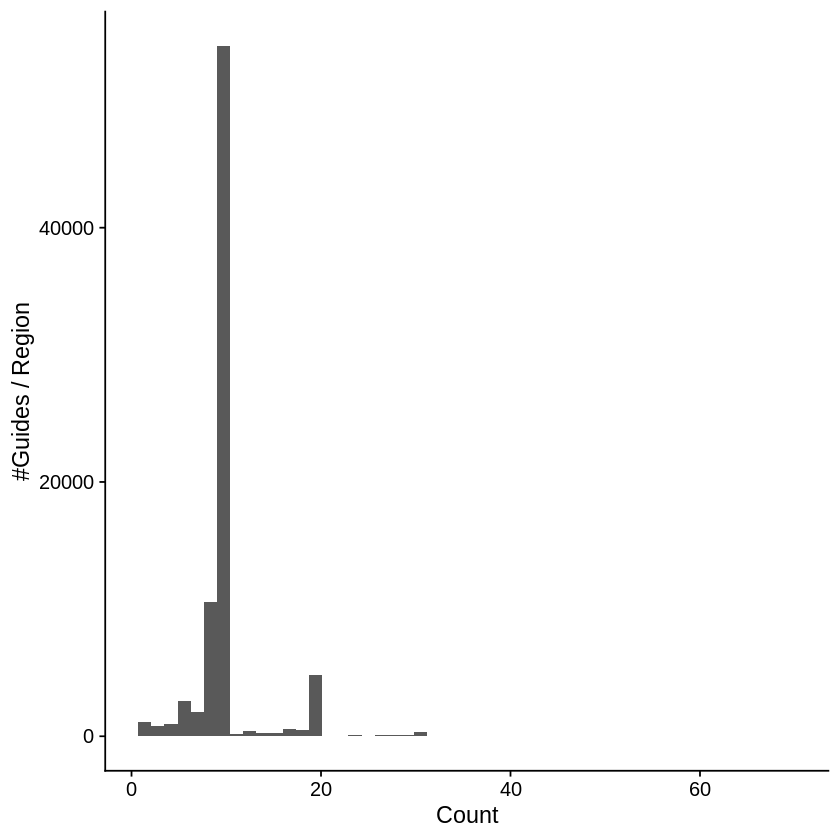

In [6]:
dat = dat_peak_score_summary
gpt = ggplot(dat, aes(x=Count)) + 
    geom_histogram(bins = 50) + 
    labs(y="#Guides / Region") +
    theme_cowplot()
print(gpt)

## Save results

In [7]:
fdiry = file.path(FD_RES, "results", ASSAY, FOLDER, "summary")
fname = "results.score.tsv"
fpath = file.path(fdiry, fname)

dat = dat_peak_score_arrange
write_tsv(dat, fpath)

In [8]:
fdiry = file.path(FD_RES, "results", ASSAY, FOLDER, "summary")
fname = "results.summary.tsv"
fpath = file.path(fdiry, fname)

dat = dat_peak_score_summary
write_tsv(dat, fpath)